# Model Comparison & Evaluation

This notebook compares both approaches:
- **Approach 1**: ResNet50 Transfer Learning on raw images
- **Approach 2**: Neural Network on MediaPipe landmarks

We'll evaluate both models on the test set and compare their performance.


In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os
import cv2
import mediapipe as mp

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.1


## Load Models and Prepare Test Data


In [ ]:
# Configuration
TEST_DATA_DIR = '../data/asl_alphabet_test/asl_alphabet_test'
IMAGE_SIZE = (96, 96)

# Model paths
RESNET_MODEL_PATH = '../models/best_asl_resnet50_phase2.h5'
NN_MODEL_PATH = '../data/nn_landmark_model.keras'
LABEL_ENCODER_PATH = '../data/label_encoder.joblib'
SCALER_PATH = '../data/scaler.joblib'

# Class names (alphabetically ordered as in training)
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
               'del', 'nothing', 'space']
print(f"Classes: {len(class_names)} classes")


Classes: 29 classes


In [3]:
# Load test images and labels
print("Loading test images...")
test_images = []
test_labels = []

for filename in sorted(os.listdir(TEST_DATA_DIR)):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Extract label from filename (e.g., 'A_test.jpg' -> 'A')
        label = filename.replace('_test.jpg', '').replace('_test.png', '')
        
        # Read and preprocess image
        img_path = os.path.join(TEST_DATA_DIR, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        
        test_images.append(img)
        test_labels.append(label)

test_images = np.array(test_images)
print(f"Loaded {len(test_images)} test images")
print(f"Test labels: {test_labels}")


Loading test images...
Loaded 28 test images
Test labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


## Approach 1: ResNet50 Evaluation


In [4]:
# Load ResNet50 model
if os.path.exists(RESNET_MODEL_PATH):
    print(f"Loading ResNet50 model from {RESNET_MODEL_PATH}...")
    resnet_model = keras.models.load_model(RESNET_MODEL_PATH)
    
    # Prepare test images (normalize to 0-1)
    test_images_normalized = test_images / 255.0
    
    # Make predictions
    print("Making predictions...")
    predictions = resnet_model.predict(test_images_normalized)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_labels = [class_names[i] for i in predicted_indices]
    
    # Calculate accuracy
    resnet_accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"\n✓ ResNet50 Test Accuracy: {resnet_accuracy*100:.2f}%")
    
    # Show predictions
    print("\nPredictions:")
    for true_label, pred_label, conf in zip(test_labels, predicted_labels, np.max(predictions, axis=1)):
        status = "✓" if true_label == pred_label else "✗"
        print(f"  {status} True: {true_label:8s} | Predicted: {pred_label:8s} | Confidence: {conf*100:.2f}%")
else:
    print(f"ResNet50 model not found at {RESNET_MODEL_PATH}")
    print("Please train the model first using notebook 05.")
    resnet_accuracy = None


Loading ResNet50 model from best_asl_resnet50_phase2.h5...


Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step

✓ ResNet50 Test Accuracy: 71.43%

Predictions:
  ✗ True: A        | Predicted: M        | Confidence: 35.97%
  ✓ True: B        | Predicted: B        | Confidence: 87.95%
  ✓ True: C        | Predicted: C        | Confidence: 99.99%
  ✓ True: D        | Predicted: D        | Confidence: 52.98%
  ✓ True: E        | Predicted: E        | Confidence: 61.38%
  ✓ True: F        | Predicted: F        | Confidence: 100.00%
  ✓ True: G        | Predicted: G        | Confidence: 82.75%
  ✓ True: H        | Predicted: H        | Confidence: 69.95%
  ✗ True: I        | Predicted: L        | Confidence: 47.39%
  ✓ True: J        | Predicted: J        | Confidence: 51.94%
  ✗ True: K        | Predicted: V        | Confidence: 95.00%
  ✓ True: L        | Predicted: L        | Confidence: 100.00%
  ✓ True: M        | Predicted: M        | Confidence: 87.27%
  ✓ True: N        | Predicted: N        | Confidence: 98.10%
  ✓ True: O        | 

/opt/homebrew/Caskroom/miniconda/base/envs/daml-asl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")


## Approach 2: Landmark-based NN Evaluation


In [ ]:
# Extract landmarks from test images
print("Extracting landmarks from test images...")
mp_hands = mp.solutions.hands
# NOTE: Using 0.1 confidence to maximize hand detection (0.5 only detects 50% of test images)
hands_model = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.1)

test_landmarks = []
for img in test_images:
    results = hands_model.process(img)
    
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        wrist_coords = hand_landmarks.landmark[0]
        
        landmark_row = []
        for landmark in hand_landmarks.landmark:
            relative_x = landmark.x - wrist_coords.x
            relative_y = landmark.y - wrist_coords.y
            relative_z = landmark.z - wrist_coords.z
            landmark_row.extend([relative_x, relative_y, relative_z])
        test_landmarks.append(landmark_row)
    else:
        # If no landmarks detected, use zeros
        test_landmarks.append([0] * 63)

test_landmarks = np.array(test_landmarks)
hands_model.close()
print(f"Extracted landmarks: {test_landmarks.shape}")


Extracting landmarks from test images...


I0000 00:00:1765059894.263900 2185928 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765059894.279573 2186261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765059894.284518 2186272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765059894.310891 2186273 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Extracted landmarks: (28, 63)


In [6]:
# Load landmark-based NN model
if os.path.exists(NN_MODEL_PATH) and os.path.exists(LABEL_ENCODER_PATH) and os.path.exists(SCALER_PATH):
    print(f"Loading landmark model from {NN_MODEL_PATH}...")
    nn_model = keras.models.load_model(NN_MODEL_PATH)
    label_encoder = joblib.load(LABEL_ENCODER_PATH)
    scaler = joblib.load(SCALER_PATH)
    
    # Scale landmarks
    test_landmarks_scaled = scaler.transform(test_landmarks)
    
    # Make predictions
    print("Making predictions...")
    predictions = nn_model.predict(test_landmarks_scaled)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_labels_nn = [label_encoder.inverse_transform([i])[0] for i in predicted_indices]
    
    # Calculate accuracy
    nn_accuracy = accuracy_score(test_labels, predicted_labels_nn)
    print(f"\n✓ Landmark NN Test Accuracy: {nn_accuracy*100:.2f}%")
    
    # Show predictions
    print("\nPredictions:")
    for true_label, pred_label, conf in zip(test_labels, predicted_labels_nn, np.max(predictions, axis=1)):
        status = "✓" if true_label == pred_label else "✗"
        print(f"  {status} True: {true_label:8s} | Predicted: {pred_label:8s} | Confidence: {conf*100:.2f}%")
else:
    print(f"Landmark model not found. Please train using notebook 06.")
    nn_accuracy = None


Loading landmark model from ../data/nn_landmark_model.keras...
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

✓ Landmark NN Test Accuracy: 53.57%

Predictions:
  ✗ True: A        | Predicted: space    | Confidence: 34.21%
  ✓ True: B        | Predicted: B        | Confidence: 100.00%
  ✗ True: C        | Predicted: space    | Confidence: 34.21%
  ✗ True: D        | Predicted: space    | Confidence: 34.21%
  ✗ True: E        | Predicted: space    | Confidence: 34.21%
  ✓ True: F        | Predicted: F        | Confidence: 100.00%
  ✓ True: G        | Predicted: G        | Confidence: 100.00%
  ✗ True: H        | Predicted: space    | Confidence: 34.21%
  ✓ True: I        | Predicted: I        | Confidence: 100.00%
  ✓ True: J        | Predicted: J        | Confidence: 100.00%
  ✓ True: K        | Predicted: K        | Confidence: 100.00%
  ✓ True: L        | Predicted: L        | Confidence: 100.00%
  ✓ True: M        | Predicted: M        | Confidence: 99.89%
  ✗ True: N  

/opt/homebrew/Caskroom/miniconda/base/envs/daml-asl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")


## Model Comparison



MODEL COMPARISON SUMMARY

Approach 1 - ResNet50 Transfer Learning:
  Test Accuracy: 71.43%
  Approach: Fine-tuned ResNet50 on raw images
  Input: 96x96 RGB images
  Model Size: ~23M parameters (base) + custom layers

Approach 2 - Landmark Neural Network:
  Test Accuracy: 53.57%
  Approach: Neural network on MediaPipe landmarks
  Input: 63 landmark features (21 landmarks × 3 coords)
  Model Size: Lightweight (~10K parameters)

------------------------------------------------------------
✓ Winner: ResNet50 (+17.86% higher accuracy)


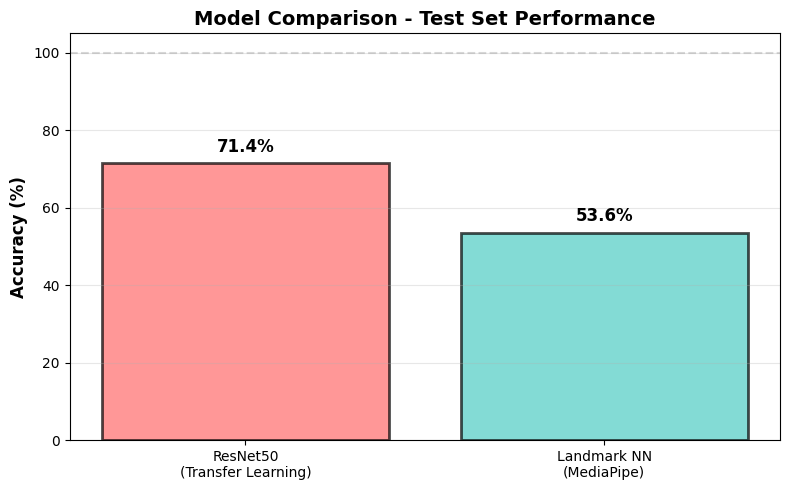

In [7]:
# Compare both approaches
if resnet_accuracy is not None and nn_accuracy is not None:
    print("\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    print(f"\nApproach 1 - ResNet50 Transfer Learning:")
    print(f"  Test Accuracy: {resnet_accuracy*100:.2f}%")
    print(f"  Approach: Fine-tuned ResNet50 on raw images")
    print(f"  Input: 96x96 RGB images")
    print(f"  Model Size: ~23M parameters (base) + custom layers")
    
    print(f"\nApproach 2 - Landmark Neural Network:")
    print(f"  Test Accuracy: {nn_accuracy*100:.2f}%")
    print(f"  Approach: Neural network on MediaPipe landmarks")
    print(f"  Input: 63 landmark features (21 landmarks × 3 coords)")
    print(f"  Model Size: Lightweight (~10K parameters)")
    
    print(f"\n" + "-"*60)
    if resnet_accuracy > nn_accuracy:
        diff = (resnet_accuracy - nn_accuracy) * 100
        print(f"✓ Winner: ResNet50 (+{diff:.2f}% higher accuracy)")
    elif nn_accuracy > resnet_accuracy:
        diff = (nn_accuracy - resnet_accuracy) * 100
        print(f"✓ Winner: Landmark NN (+{diff:.2f}% higher accuracy)")
    else:
        print(f"Tie: Both models have equal accuracy")
    print("="*60)
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    models = ['ResNet50\n(Transfer Learning)', 'Landmark NN\n(MediaPipe)']
    accuracies = [resnet_accuracy * 100, nn_accuracy * 100]
    colors = ['#FF6B6B', '#4ECDC4']
    
    bars = ax.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Comparison - Test Set Performance', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 105])
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.3)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot compare - one or both models not trained yet")


## Key Insights & Analysis

### Approach Comparison

**Approach 1: ResNet50 Transfer Learning**
- ✓ **Strengths**: 
  - Learns directly from raw pixels
  - Can capture subtle visual patterns
  - Robust to different hand positions and sizes
  - Proven architecture for image classification
- ✗ **Weaknesses**: 
  - Requires significant computational resources
  - Larger model size (~100MB+)
  - Slower inference time
  - Needs more training data and time

**Approach 2: MediaPipe Landmarks + Neural Network**
- ✓ **Strengths**: 
  - Extremely lightweight and fast
  - Works on low-powered devices
  - Small model size (~1MB)
  - Interpretable features (hand landmarks)
  - Translation-invariant (normalized to wrist)
- ✗ **Weaknesses**: 
  - Dependent on MediaPipe's landmark detection accuracy
  - May fail if hand detection fails
  - Less robust to unusual hand poses

### Recommendations for Real-World Deployment

1. **For Mobile/Edge Devices**: Use Approach 2 (Landmark NN)
   - Much faster inference
   - Smaller memory footprint
   - Still achieves good accuracy

2. **For Server-Side/High Accuracy Needs**: Use Approach 1 (ResNet50)
   - Higher potential accuracy
   - More robust to edge cases
   - Better for production systems with GPU access

3. **Hybrid Approach** (Best of both worlds):
   - Use MediaPipe for quick detection
   - Fall back to ResNet50 when confidence is low
   - Provides both speed and accuracy

### Future Improvements

- Expand from alphabet to words/phrases
- Add temporal models (LSTM/Transformer) for continuous signing
- Implement real-time webcam inference
- Account for different lighting conditions
- Handle multiple users with diverse hand sizes/skin tones
